# 1.この課題の目的
RNNの活用例を知る
以下の要件をすべて満たしていた場合、合格とします。

※Jupyter Notebookを使い課題に沿った検証や説明ができている。

# 2.機械翻訳
RNNの最も基本的な活用例としては機械翻訳があります。これは時系列を入力し、時系列を出力するSequence to Sequenceの手法によって行えます。

# 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換が行えるのでこれを動かしてください。

[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

（例）

- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定

## 使用するクラスをインポート

In [5]:
from IPython.display import display
from PIL import Image
import os

In [2]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Using TensorFlow backend.


Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.9203 - val_loss: 0.9555
Epoch 2/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.7358 - val_loss: 0.7735
Epoch 3/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.6216 - val_loss: 0.6776
Epoch 4/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.5646 - val_loss: 0.6350
Epoch 5/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.5237 - val_loss: 0.5905
Epoch 6/100
8000/8000 [==============================] - 22s 3ms/step

8000/8000 [==============================] - 25s 3ms/step - loss: 0.0985 - val_loss: 0.6032
Epoch 69/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.0971 - val_loss: 0.6001
Epoch 70/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.0953 - val_loss: 0.6054
Epoch 71/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.0942 - val_loss: 0.6088
Epoch 72/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.0927 - val_loss: 0.6226
Epoch 73/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.0911 - val_loss: 0.6224
Epoch 74/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.0899 - val_loss: 0.6311
Epoch 75/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.0886 - val_loss: 0.6308
Epoch 76/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.0874 - val_loss: 0.6299
Epoch 77/100
8000/8000 [==============================] - 24s 3ms/st

/Users/takahiro/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Go on.
Decoded sentence: Poursuivez.

-
Input sentence: Hello!
Decoded sentence: Salut !

-
Input sentence: Hello!
Decoded sentence: Salut !



## コードリーディング
### 51行目〜55行目　ライブラリのimport
```python
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
```

### 50行目〜55行目　処理に必要な変数の宣言
```python
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'
```

| 変数名      | 内容                             |
|-------------|----------------------------------|
| batch_size  | バッチサイズ                     |
| epochs      | エポック数                       |
| latent_dim  | 符号化空間の潜在次元             |
| num_samples | トレーニングするサンプル数       |
| data_path   | 辞書ファイルのフォルダパス |

### 57行目〜76行目　辞書のベクトル化
```python
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
```

### 78行目〜89行目　辞書のソートと文字数の計算と表示
```python
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
```

### 91行目〜94行目　辞書にindexを付与
```python
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])
```

### 96行目〜104行目　データ格納用のnumpy配列を作成
```python
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
```

### 106行目〜115行目　単語と文字が一致する部分を確認
```python
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
```


### 117行目〜120行目　エンコーダー
```python
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]
```

### 124行目〜133行目　デコーダー
```python
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
```

### 135行目〜137行目　モデルの作成
```python
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
```

### 139行目〜140行目　コンパイル
```python
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
```

### 141行目〜144行目　コンパイル
```python
model.fit([encoder_input_data,
           decoder_input_data],
          decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
```

### 145行目〜146行目　モデルの保存
```python
# Save model
model.save('s2s.h5')
```

### 156行目〜157行目　エンコーダの作成
```python
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
```

### 156行目〜157行目　デコーダーの設定
```python
#デコーダー
#デコーダへの入力
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
```


### 167行目〜168行目　デコーダーの作成
```python
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
```

### 170行目〜175行目　indexと文字が格納された辞書
```python
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
```

### 178行目　デコードの処理をまとめたメソッドの定義
```python
def decode_sequence(input_seq):
```

### 180行目　デコードの処理をまとめたメソッドの定義
```python
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
```

### 183行目　デコードの処理をまとめたメソッドの定義
```python
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
```

### 185行目　文章の最初の位置を1とする
```python
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
```

### 187行目〜190行目　ループを回すための設定
```python
# Sampling loop for a batch of sequences
# (to simplify, here we assume a batch of size 1).
stop_condition = False
decoded_sentence = ''
```

### 191行目　ループ開始
```python
while not stop_condition:
```

### 192行目〜193行目　ループを回すための設定
```python
output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

# Sample a token
sampled_token_index = np.argmax(output_tokens[0, -1, :])
sampled_char = reverse_target_char_index[sampled_token_index]
decoded_sentence += sampled_char
```

### 192行目〜198行目　ループを回すための設定
```python
# Sample a token
sampled_token_index = np.argmax(output_tokens[0, -1, :])
sampled_char = reverse_target_char_index[sampled_token_index]
decoded_sentence += sampled_char
```

### 200行目〜204行目　長さがmaxになればstop_conditionをTrue
```python
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
```

### 206行目〜208行目　target_seqを初期化する
```python
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
```

### 210行目〜211行目　states_valueを更新
```python
        # Update states
        states_value = [h, c]
```

### 216行目〜223行目　デコードの実施
```python
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
```

# 3.イメージキャプショニング
他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、時系列を出力するImage to Sequenceの手法によって行えます。

[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。



## 3. Preprocessing

「python build_vocab.py」の実行時に「ModuleNotFoundError: No module named 'pycocotools'」を確認
- 回避策 Cコンパイラpycocotoolsをインストール
- 参考リンク[https://github.com/matterport/Mask_RCNN/issues/6](https://github.com/matterport/Mask_RCNN/issues/6)

# 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において5. Test the modelの項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

## 作業内容
### 以下のリポジトリをクローン
```python
git clone https://github.com/pdollar/coco.git
cd coco/PythonAPI/
make
python setup.py build
python setup.py install
cd ../../
git clone https://github.com/yunjey/pytorch-tutorial.git
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/
```

### データセットをダウンロード
```python
pip install -r requirements.txt
chmod +x download.sh
./download.sh
```

### 以下のサイトより学習済みに重みデータをダウンロードし実行
- [エンコーダー・デコーダー](https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0)
    - encoder-5-3000.pkl
    - decoder-5-3000.pkl
- [辞書データ](https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0)
    - vocab.pkl

### 「sample.py」の「if __name__ == '__main__':」内のdefaut=以降をダウンロードした重みファイルのエンコーダー・デコーダーのパスに変更
```python
parser.add_argument('--encoder_path', type=str, default='/Users/takahiro/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/pretrained_model/encoder-5-3000.pkl', help='path for trained encoder')

parser.add_argument('--decoder_path', type=str, default='/Users/takahiro/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/pretrained_model/decoder-5-3000.pkl', help='path for trained decoder')
```

### 任意の画像をモデルに入力し、画像の内容を説明する文章を作成
```python
os.chdir('/Users/takahiro/pytorch-tutorial/tutorials/03-advanced/image_captioning')
```

### 以下のコマンドを使用
```python
%run sample.py --image='png/example.png'
```

## 画像1

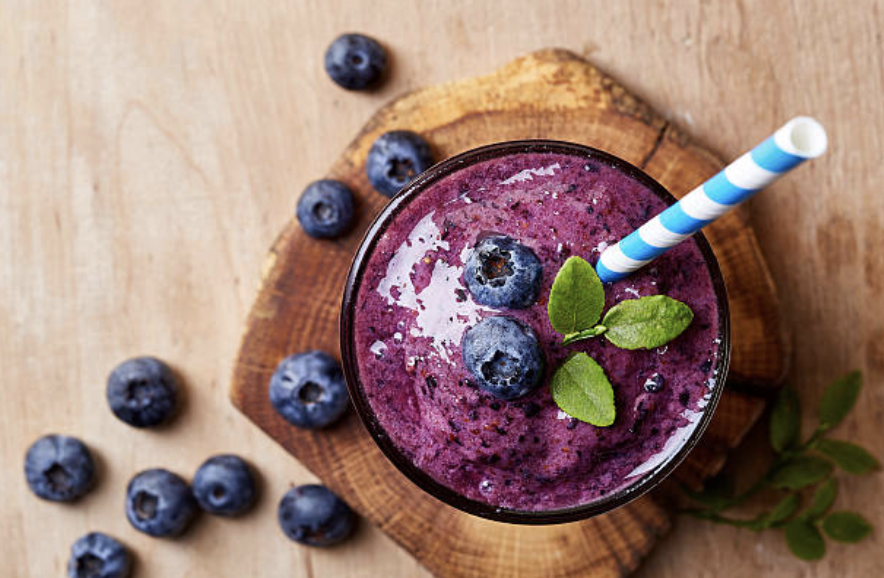

In [7]:
display(Image.open('png/sample6.png'))

### 出力→a table topped with a piece of pizza 
### 和訳→ピザをのせたテーブル
### 考察
### グラスをピザと誤って予測している
### テーブルについては正しく予測できている

### →学習データにグラスを上から撮影したデータがない？

## 画像2

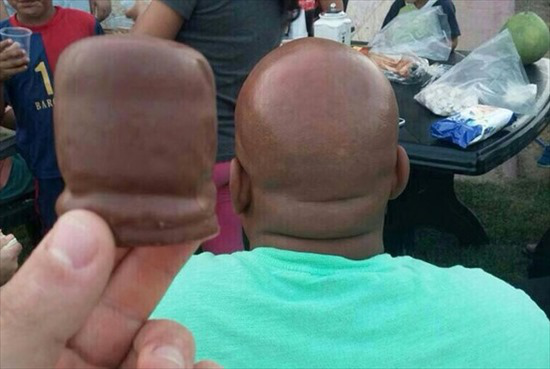

In [8]:
display(Image.open('png/sample5.jpg'))

### 出力→a man holding a hot dog in his hand .
### 和訳→ホットドッグを手に持った男
### 考察
### お菓子のような物をホットドッグと誤って予測している
 - 画像に写っているものは画像では何かを判断出来ないものの為、学習データの中で最も特徴が近いであろうホットドッグになったと思われる
 
### ホットドッグを持った男とは、後ろ姿の男性の事なのか？

## 画像3

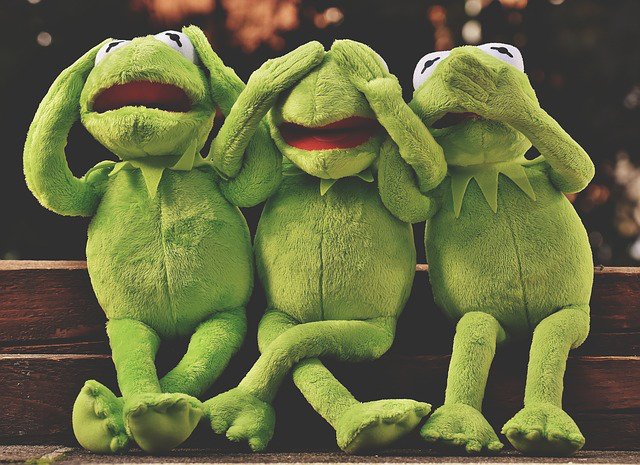

In [9]:
display(Image.open('png/sample4.jpeg'))

### 出力→a teddy bear sitting on a table next to a tree
### 和訳→木の横にあるテーブルの上に座っているテディベア
### 考察
### カエルの人形をテディベアと誤って予測している。
- テディベアという予測は誤ってはいるが人形という意味では、正解している為、学習データにテディベアはあったがカエルの人形はなかった為、正確に予測できなかったのではないかと推測される

## 画像4

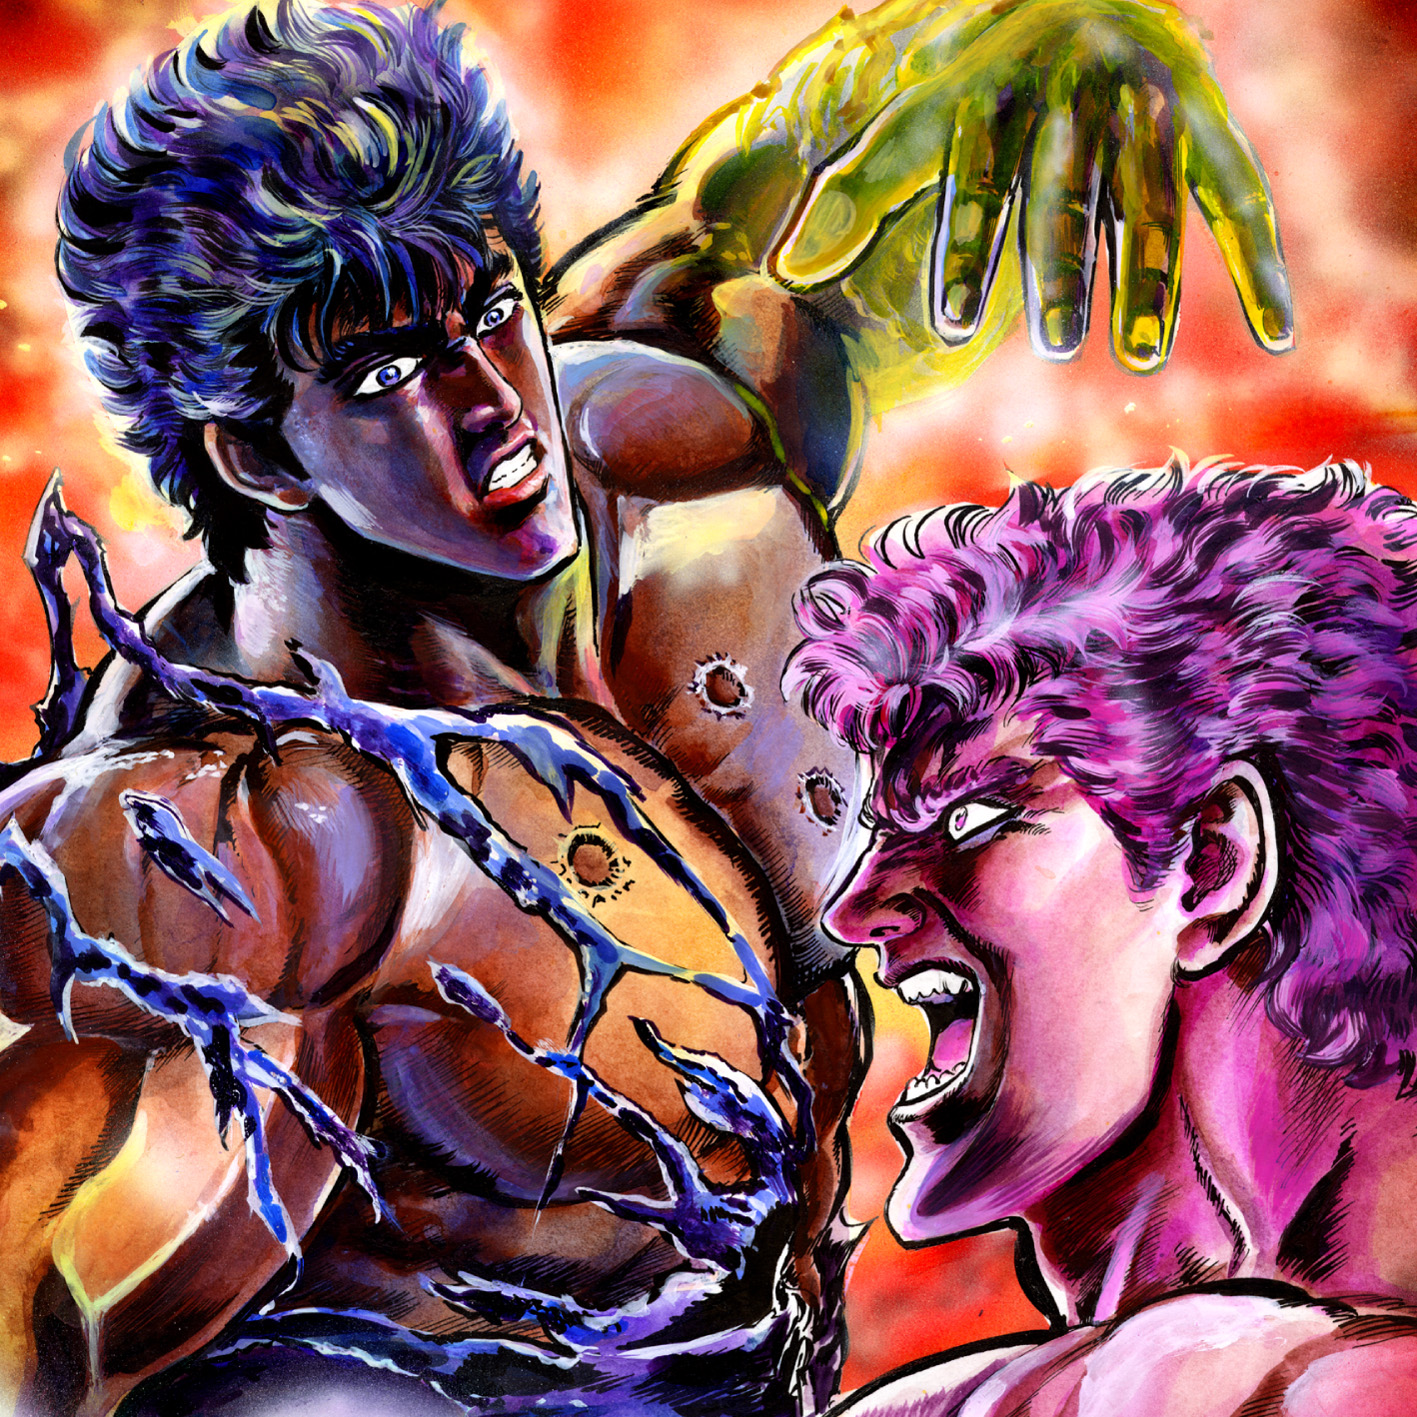

In [10]:
display(Image.open('png/sample7.jpg'))

### 出力→a man is holding a bunch of bananas
### 和訳→男性はバナナの束を持っています
### 考察
### 実写画像ではないが、男性であると正確に予測出来ている
- 学習データに今回入力した画像のようなマンガの画像があった or 学習データにはマンガはなかったが、実写の男性の特徴量とマンガの男性の特徴量が近かった為、男性と予測が出来たと想定される

### 手が光っている部分をバナナだと誤って予測している
- 光っている部分の色はバナナと同じ黄色の為、バナナと予測したと思われる

# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

## 対応①PyTorch用の学習済みの重みをKeras用に変換する

#### 深層学習モデルの変換を行うツールを使用する
##### MMdnn
- Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール。
- 対応フレームワーク　Caffe、Keras、Tensorflow、CNTK、MXNet、PyTorch、CoreML

##### 実行例　kerasモデル→ONNXモデルに変換　
   - kerasモデル「imagenet_inception_v3.h5」
   - ONNXモデル「imagenet_inception_v3.onnx」

##### 変換を行うプログラム
```python
mmconvert -sf keras -iw imagenet_inception_v3.h5 -df onnx -om imagenet_inception_v3.onnx
```

##### 補足　ONNXモデルとは？
- Open Neural Network eXchangeといい、FacebookとMicrosoftが開発したPyTorchとCaffe2の間でモデルを変換するためのフォーマット。
- 「オニキス」と発音する。


## 対応②PyTorch用プログラムをKeras用に書き換える

# 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

# 【問題5】（アドバンス課題）発展的調査
## 他の言語の翻訳を行う場合は？

問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。

## 機械翻訳の発展的手法にはどのようなものがある？

機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。

## 文章から画像生成するには？

イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。